In [64]:
# Initialize Otter
import otter
grader = otter.Notebook("projA1.ipynb")

# Project A1: Exploring Cook County Housing

<hr style="border: 1px solid #fdb515;" />
<hr style="border: 5px solid #003262;" />
<br/><br/>

## Introduction

This project explores what can be learned from an extensive housing dataset that is embedded in a dense social context in Cook County, Illinois.

In Project 05-1, I will guide through some basic Exploratory Data Analysis (EDA) to understand the structure of the data. Next, I will be adding a few new features to the dataset, while cleaning the data as well in the process.

In Project 05-2, I will specify and fit a linear model for the purpose of prediction. Finally, I will analyze the error of the model and brainstorm ways to improve the model's performance.

In [65]:
import numpy as np

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# The Data

The dataset consists of over 500,000 records from Cook County, Illinois, the county where Chicago is located. The dataset has 61 features in total; the 62nd is `Sale Price`, which I will predict with linear regression in the next part of this project. An explanation of each variable can be found in the included `codebook.txt` file. Some of the columns have been filtered out to ensure this project doesn't become overly long when dealing with data cleaning and formatting.

The data are split into training and test sets with 204,792 and 68,264 observations, respectively, but I will only be working on the training set for this part of the project.

Let's first extract the data from the `cook_county_data.zip`. Notice I didn't leave the `csv` files directly in the directory because they take up too much space without some prior compression.

In [66]:
with zipfile.ZipFile('data/cook_county_data.zip') as item:
    with item.open("cook_county_train.csv") as f:
        initial_data = pd.read_csv(f, index_col='Unnamed: 0')

In [67]:
# 204,792 observations and 62 features in training data
assert initial_data.shape == (204792, 62)
# Sale Price is provided in the training data
assert 'Sale Price' in initial_data.columns.values

The next order of business is getting a feel for the variables in our data.  A more detailed description of each variable is included in `codebook.txt`. 

I'll take a quick look at all the current columns in our initial data.

In [68]:
initial_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

In [69]:
initial_data['Description'][0]

'This property, sold on 09/14/2015, is a one-story houeshold located at 2950 S LYMAN ST.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Section 1: Contextualizing the Data

<!-- BEGIN QUESTION -->

<br><br>

---

## Part 1

Based on the columns in this dataset and the values that they take, what do you think each row represents? That is, what is the granularity of this dataset? 

Each row represents a single real estate property.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br><br>

---
## Part 2
Why was this data collected? For what purposes? By whom?

The data was collected by CCAO. They collected the data to estimate the home values so they can charge the property tax accordingly. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br><br>

---
## Part 3

Craft at least two questions about housing in Cook County that can be answered with this dataset and provide the type of analytical tool you would use to answer it (e.g. "I would create a ___ plot of ___ and ___" or "I would calculate the ___ [summary statistic] for ___ and ____"). Be sure to reference the columns that you would use and any additional datasets you would need to answer that question.

1. How does the estimated property value different from the actual sale price across different neighborhoods in Cook County?
To assess this question, I would create a scatter plot of estimate and sales price.
2. Do wealthier neighborhoods have higher property values compared to lower-income neighborhoods?
I would calculate the average sale price for each neighborhood and compare it to the median income of the neighborhood.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br><br>

---
## Part 4

Suppose now, in addition to the information already contained in the dataset, you also have access to several new columns containing demographic data about the owner, including race/ethnicity, gender, age, annual income, and occupation. Provide one new question about housing in Cook County that can be answered using at least one column of demographic data and at least one column of existing data and provide the type of analytical tool you would use to answer it.

Is there a relationship between a homeowner’s ethnicity and the likelihood of their property being over or under priced compared to its actual sale price?

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br><br>

---
## Part 5

Look at `codebook.txt` to see some of the unique regional features CCAO utilizes, such as `O’Hare Noise`. Now imagine you were in charge of predicting the `Sale Price` of houses in **your hometown** (your actual real life hometown/city - not the data provided). Propose a feature that you would want to collect specific to your location and hypothesize why it might be useful in predicting the sale price of houses.

I would like to collect the view in your house for my hometown. Most of the houses in my hometown have a different view of the Haeundae beach. I think this feature will be useful in predicting the sale pirce of houses because the scenary the house has is an important feature.

<!-- END QUESTION -->

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Section 2: Exploratory Data Analysis

This dataset was collected by the [Cook County Assessor's Office](https://datacatalog.cookcountyil.gov/Property-Taxation/Archive-Cook-County-Assessor-s-Residential-Sales-D/5pge-nu6u) in order to build a model to predict the monetary value of a home. You can read more about data collection in the CCAO’s [Residential Data Integrity Preliminary Report](https://gitlab.com/ccao-data-science---modeling/ccao_sf_cama_dev/-/blob/master/documentation/Preliminary%20Report%20on%20Data%20Integrity%20June%207,%202019.pdf). In Project A2, you will be building a linear regression model that predicts sales prices using training data, but it's important to first understand how the structure of the data informs such a model. In this section, I will make a series of exploratory visualizations and feature engineering in preparation for that prediction task.

Note that I will perform EDA on the **initial data**.

### Sale Price
I begin by examining the distribution of our target variable `Sale Price`. I have provided the following helper method `plot_distribution` that I can use to visualize the distribution of the `Sale Price` using both the histogram and the box plot at the same time.

In [70]:
def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)

    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        x=data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    # Remove some axis text
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    # Put the two plots together
    plt.subplots_adjust(hspace=0)
    fig.suptitle("Distribution of " + label)

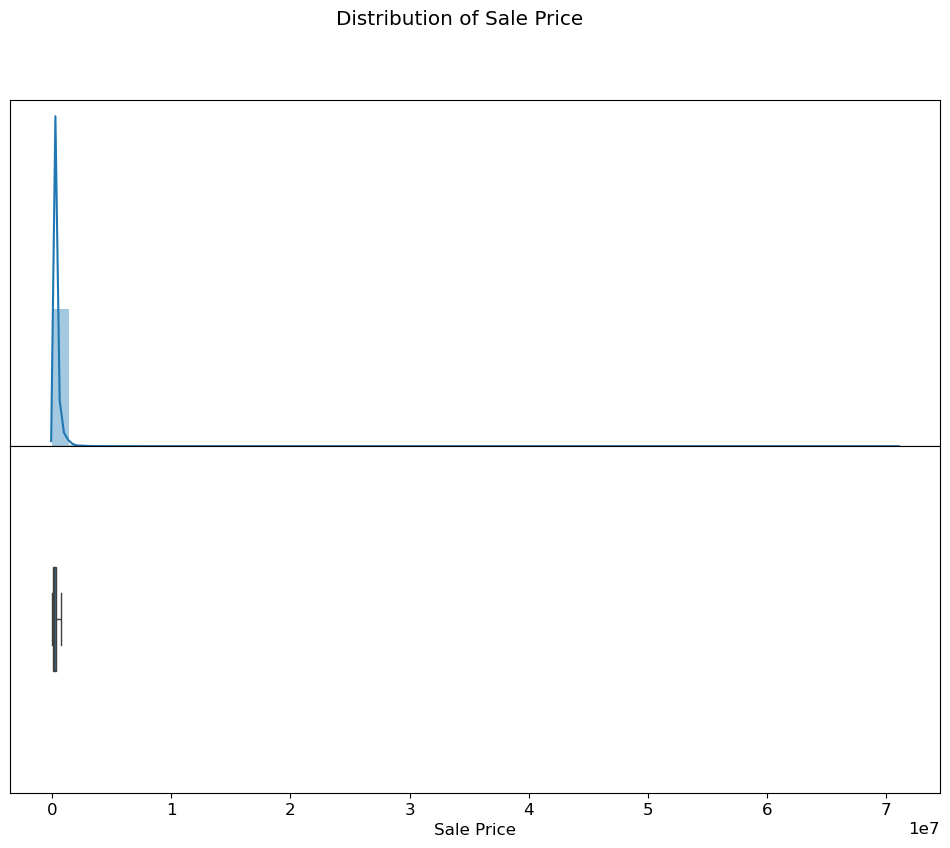

In [71]:
plot_distribution(initial_data, label='Sale Price')

I can see that the data is highly skewed to the right currently, probably because of some extremely expensive houses. To get a clearer view of the distribution, run the following cell to examine a more limited range of house prices from [\\$0, \\$1,000,000]. 

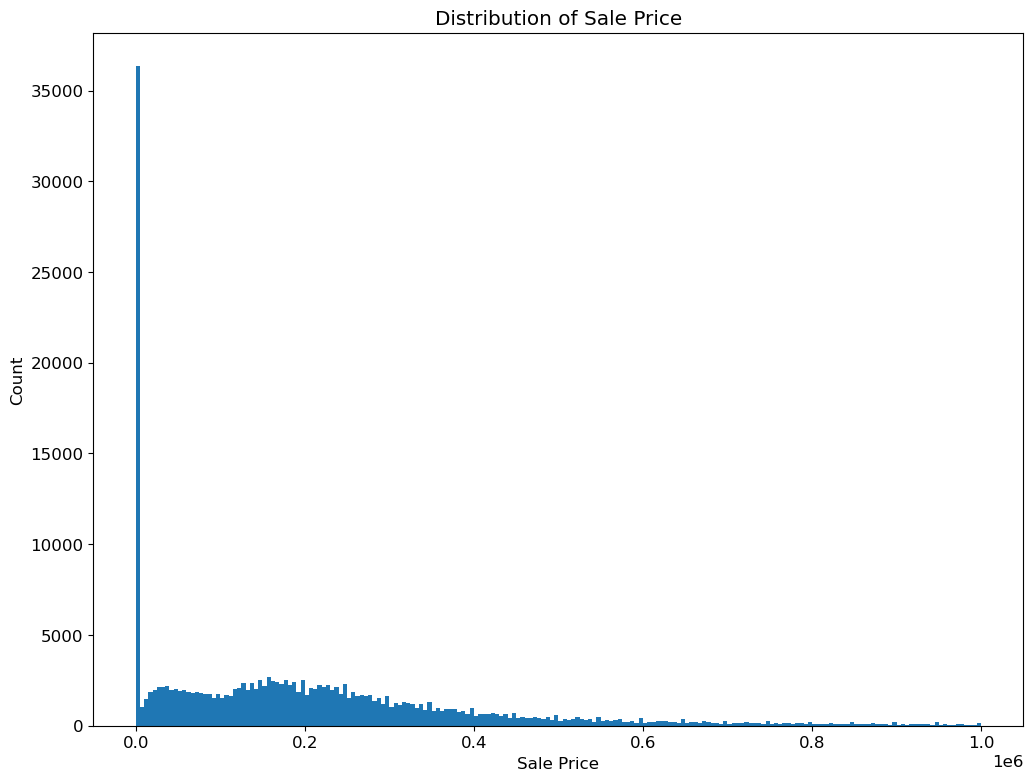

In [27]:
no_right_outliers = initial_data[initial_data['Sale Price'] <= 1000000]['Sale Price']
plt.hist(no_right_outliers, bins=200)
plt.xlabel("Sale Price")
plt.ylabel("Count")
plt.title("Distribution of Sale Price")
plt.show()

Interestingly, I also see this spike near in the smallest bin of our `Sale Price` distribution, something that wasn't immediately evident from our initial plot. Run the following cell to see which values are the most common.

In [72]:
initial_data['Sale Price'].value_counts()

Sale Price
1         35546
250000     1252
200000     1232
150000     1189
175000     1118
          ...  
216756        1
70050         1
358590        1
215700        1
142515        1
Name: count, Length: 14720, dtype: int64

While I don't know the exact reason why so many houses were reported as \\$1 (most likely a placeholder value of some sort), including these data points in any model would heavily skew the fit. After all, most houses are worth more than \\$1!

<br><br>

---
## Part 1

Our findings with the \\$1 entries indicates something interesting may be happening with small valued `Sale Price`s. In the cell below, I will use `value_counts()` to assess the count of entries for `Sale Prices` in the range of [\\$0, \\$500). 

In [73]:
low_price_sales = initial_data[initial_data['Sale Price'] < 500]['Sale Price']
low_price_counts = low_price_sales.value_counts()
q2a = list(low_price_counts.head(3).index)

This exploration has indicated that moving forward we should probably pick a cutoff to get rid of smaller, probably unrepresentative `Sale Price`s. As a result, moving forward I will only look at households whose price is at least \\$500 dollars. While this cutoff is slightly arbitrary, this decision I made to address these unrealistically low values. 

On the other hand, there are also the upper-bound outliers that skewed our data in the first place. Run the cell below to find the proportion of how many buildings sold for over \\$1,000,000.

In [75]:
len(initial_data[initial_data['Sale Price'] > 1000000]) / len(initial_data[initial_data['Sale Price'] >= 500])

0.034114520129520334

Since there's only around 3% (or 5,000) buildings that have sold over \\$1,000,000 it would definitely be reasonable to build a model for the [\\$500, \\$1,000,000] range. For Proj05-1 though, I'm going to try and build a model to handle the entire range from [\\$500, infinity). As a result, I will need to reason with how the outliers shape the distribution of points. One way I can make my initial visualization more legible is by log-transforming our data to neutralize the impact of the right outliers.

<br><br>

---
## Part 2

As previously established to zoom in on the visualization of most households, I will focus only on a subset of `Sale Price` for this project. In addition, it may be a good idea to apply a log transformation to `Sale Price`. In the cell below, assign `training_data` to a new `DataFrame` that is the same as `initial_data` **except with the following changes**:

- `training_data` should contain only households whose price is at least $500.
- `training_data` should contain a new `Log Sale Price` column that contains the log-transformed sale prices.

In [76]:
training_data = initial_data[initial_data["Sale Price"] >= 500].copy()
training_data['Log Sale Price'] = np.log(training_data['Sale Price'])
training_data

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Sale Half of Year,Most Recent Sale,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price
1,13272240180000,202,120,3780.0,71,0.0,2.0,1.0,1.0,1.0,...,1,1.0,9.6,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244
2,25221150230000,202,210,4375.0,70,0.0,2.0,1.0,2.0,3.0,...,1,0.0,11.2,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0,9.998798
3,10251130030000,203,220,4375.0,17,0.0,3.0,1.0,1.0,3.0,...,2,1.0,6.3,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0,12.323856
4,31361040550000,202,120,8400.0,32,0.0,3.0,1.0,2.0,3.0,...,1,0.0,6.3,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705
6,30314240080000,203,181,10890.0,37,0.0,1.0,1.0,1.0,3.0,...,2,1.0,10.9,1,1.0,181,37181,"This property, sold on 10/26/2017, is a one-st...",10890.0,11.512925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204787,25163010260000,202,321,4375.0,72,0.0,2.0,1.0,1.0,1.0,...,2,0.0,5.8,1,1.0,321,72321,"This property, sold on 07/23/2014, is a one-st...",4375.0,10.521372
204788,5063010090000,204,21,16509.0,23,0.0,1.0,1.0,1.0,1.0,...,1,1.0,9.3,1,1.0,21,2321,"This property, sold on 03/27/2019, is a one-st...",16509.0,12.323856
204789,16333020150000,202,90,3810.0,15,0.0,2.0,1.0,1.0,1.0,...,1,1.0,5.9,1,1.0,90,1590,"This property, sold on 01/31/2014, is a one-st...",3810.0,11.813030
204790,9242030500000,203,80,6650.0,22,0.0,2.0,1.0,1.0,3.0,...,1,1.0,6.0,1,1.0,80,2280,"This property, sold on 02/22/2018, is a one-st...",6650.0,12.879017


I'll create a new distribution plot using the log-transformed sale prices. As a sanity check, you should see that the distribution for `Log Scale Price` is much more uniform.

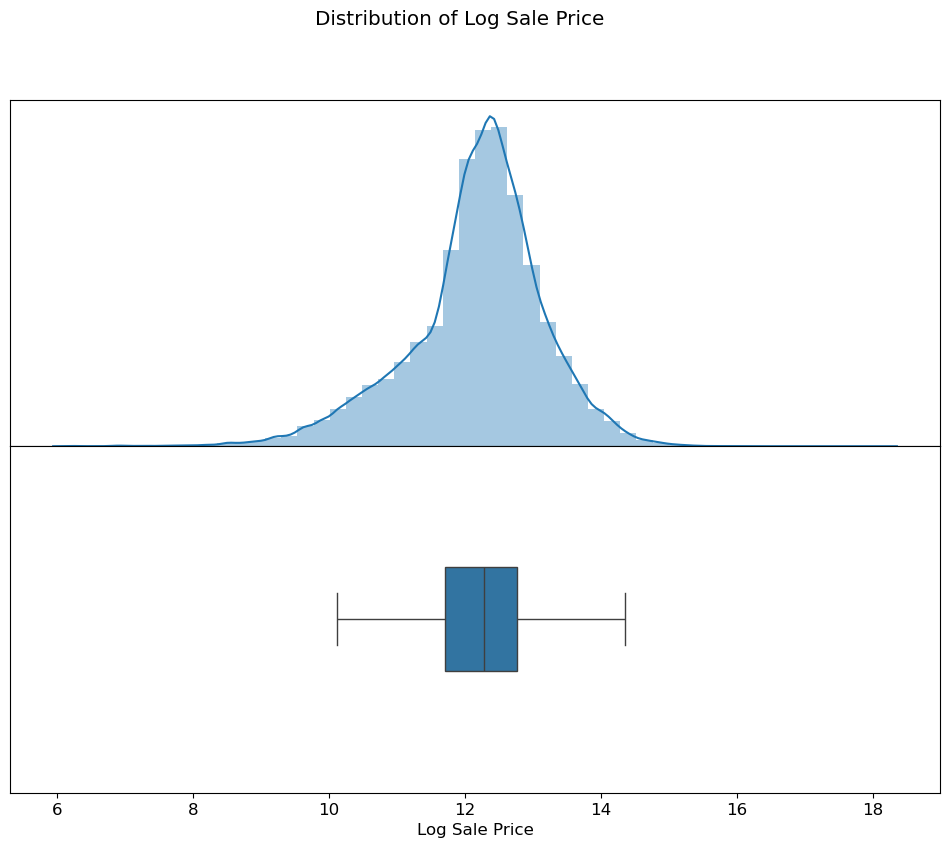

In [78]:
plot_distribution(training_data, label='Log Sale Price');

<br><br>

---
## Part 3-1

Next, I want to explore if there is any correlation between `Log Sale Price` and the total area occupied by the property. The `codebook.txt` file tells me the column `Building Square Feet` should do the trick — it measures "(from the exterior) the total area, in square feet, occupied by the building".

Let's also apply a log transformation to the `Building Square Feet` column.

In the following cell, create a new column `Log Building Square Feet` in our `training_data` that contains the log-transformed area occupied by each property. 

In [41]:
training_data['Log Building Square Feet'] = np.log(training_data['Building Square Feet'])
training_data.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Most Recent Sale,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet
1,13272240180000,202,120,3780.0,71,0.0,2.0,1.0,1.0,1.0,...,1.0,9.6,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244,6.904751
2,25221150230000,202,210,4375.0,70,0.0,2.0,1.0,2.0,3.0,...,0.0,11.2,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0,9.998798,6.810142
3,10251130030000,203,220,4375.0,17,0.0,3.0,1.0,1.0,3.0,...,1.0,6.3,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0,12.323856,7.068172
4,31361040550000,202,120,8400.0,32,0.0,3.0,1.0,2.0,3.0,...,0.0,6.3,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705,6.855409
6,30314240080000,203,181,10890.0,37,0.0,1.0,1.0,1.0,3.0,...,1.0,10.9,1,1.0,181,37181,"This property, sold on 10/26/2017, is a one-st...",10890.0,11.512925,7.458186


<!-- BEGIN QUESTION -->

<br><br>

---
## Part 3-2

In the visualization below, I created a `jointplot` with `Log Building Square Feet` on the x-axis, and `Log Sale Price` on the y-axis. In addition, I will fit a simple linear regression line through the bivariate scatter plot in the middle.

Based on the following plot, guess if `Log Building Square Feet` would make a good candidate as one of the features for our model? Why or why not?


I think log building square feet is a good candidate. That is because it shows a strong correlation with log sale price. I think including it as a feature can improve the model's ability to predict property values accurately.

<!-- END QUESTION -->

<br><br>

---
## Part 4-1

Continuing from the previous part, as I explore the dataset, I might still run into more outliers that prevent me from creating a clear visualization or capturing the trend of the majority of the houses. 

I will write a function `remove_outliers` that removes outliers from the dataset based on a threshold value of a variable. For example, `remove_outliers(training_data, 'Building Square Feet', lower=500, upper=8000)` should return a copy of `data` with only observations that satisfy `Building Square Feet` less than 8000 (exclusive) and `Building Square Feet` greater than 500 (exclusive).

In [79]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (DataFrame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than or equal to this will be removed
      upper (numeric): observations with values higher than or equal to this will be removed
    
    Output:
      a DataFrame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    return data[(data[variable] > lower) & (data[variable] < upper)].copy()

<br><br>

---
## Part 4-2

To give an example on how `remove_outliers` might be useful in the future, I will plot the distribution of the attribute `Estimate (Land)` below using `plot_distribution` with the provided code below. From `codebook.txt`, `Estimate (Land)` estimates the market value of a property’s land from the prior tax year. 

“At least 95% of the properties in `training_data` have `Estimate (Land)` values less than $500,000.00”

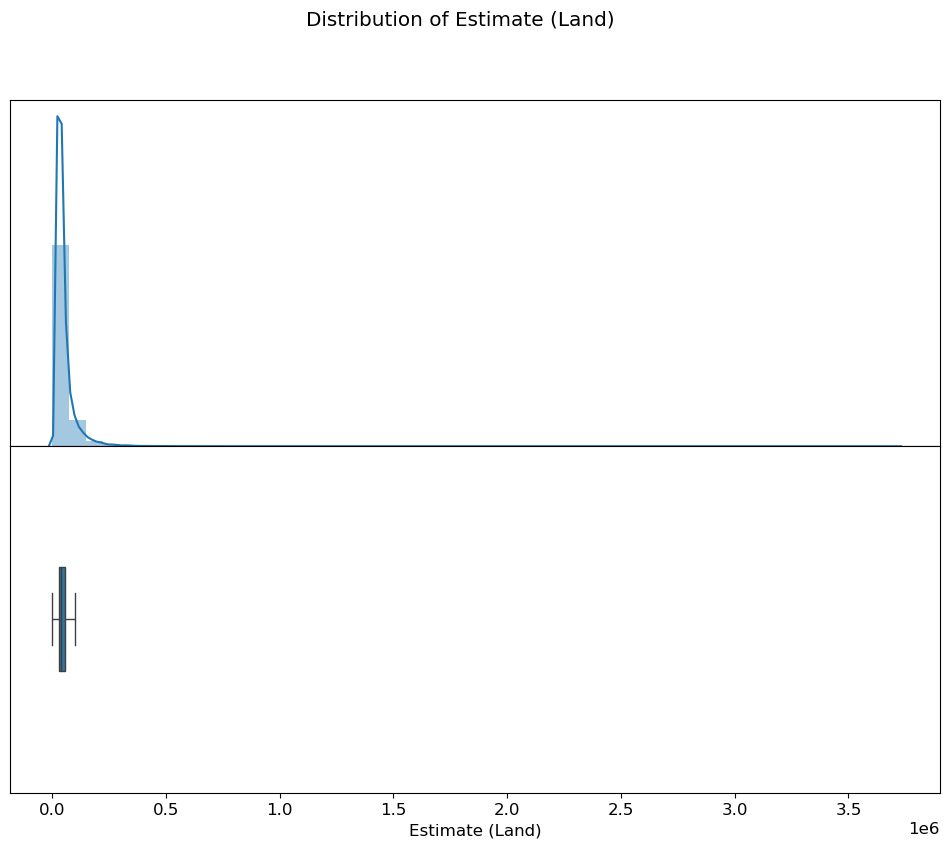

In [81]:
# Run this to see the distribution!
plot_distribution(training_data, label='Estimate (Land)');

<br><br>

---
## Part 4-3

Similar to the exploration of `Sale Price` in Section 2, I may have observed that `Estimate (Land)` contains some points that heavily skew its distribution. One way to address these issues is to transform the data to a different scale, as we did with `Sale Price`. Another way is to remove outliers. 

In this subpart, I define an outlier as any point that is 1.5 interquartile ranges above Q3 or below Q1 (exclusive of the boundary). Assign `IQR` to the interquartile range of `Estimate (Land)`. Then, assign `q4c_training_data` to `training_data` with only rows which are not considered `Estimate (Land)` outliers using `remove_outliers`.

In [84]:
Q1 = training_data['Estimate (Land)'].quantile(0.25)
Q3 = training_data['Estimate (Land)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
q4c_training_data = remove_outliers(training_data, 'Estimate (Land)', lower=lower_bound, upper=upper_bound)

I'll create a new distribution plot using the `Estimate (Land)` with outliers removed. As a sanity check for Question 4c, you should see that the distribution for `Estimate (Land)` is much less skewed with `q4c_training_data`!

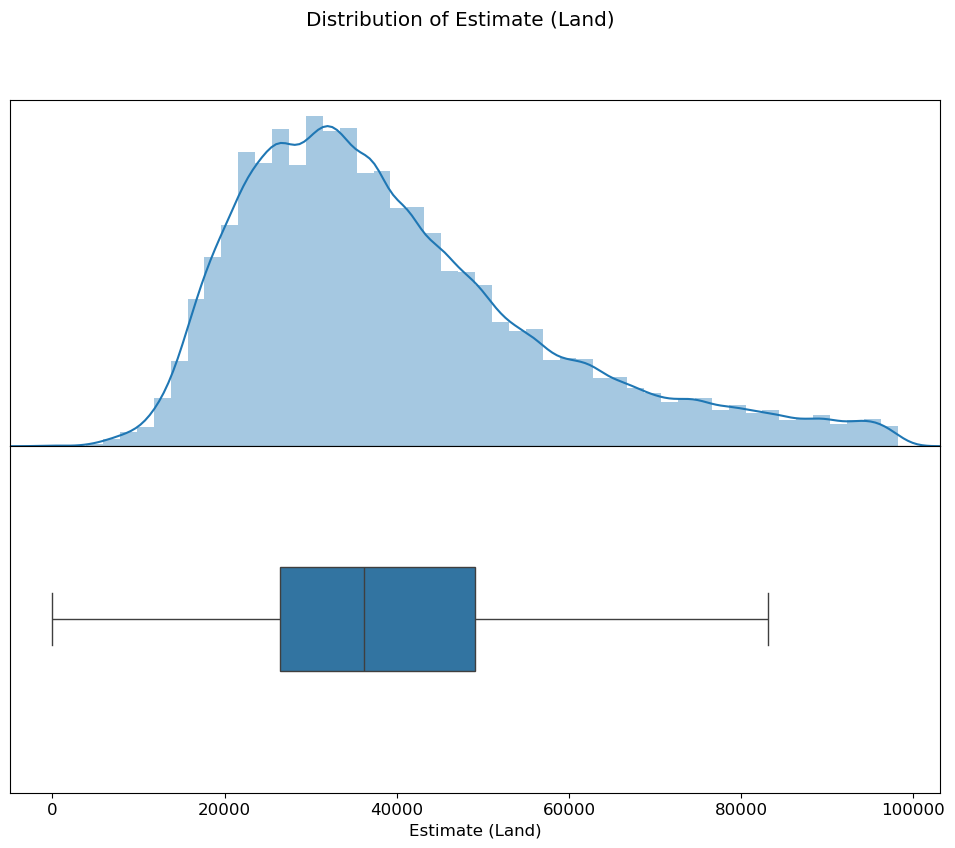

In [86]:
plot_distribution(q4c_training_data, label='Estimate (Land)');

<br><br>

---
## Part 5-1

I'll write a function `add_number_bathrooms(data)` that returns a copy of `data` with an additional column called `Bathrooms` that contains the total number of bathrooms (**as floats**) for each house. Treat missing values as zeros, if necessary.

In [89]:
def add_total_bathrooms(data):
    """
    Input:
      data (DataFrame): a DataFrame containing at least the Description column.

    Output:
      a Dataframe with a new column "Bathrooms" containing floats.

    """
    with_rooms = data.copy()
    with_rooms["Bathrooms"] = with_rooms["Description"].str.extract(r'(\d+\.?\d*) of which are bathrooms', expand=False)
    with_rooms["Bathrooms"] = with_rooms["Bathrooms"].astype(float).fillna(0)
    return with_rooms

training_data = add_total_bathrooms(training_data)

<!-- BEGIN QUESTION -->

<br><br>

---
## Part 5-2

I'll create a visualization that clearly and succinctly shows if there exists an association between  `Bathrooms` and `Log Sale Price`. A good visualization should satisfy the following requirements:
- It should avoid overplotting.
- It should have clearly labeled axes and a succinct title.
- It should convey the strength of the correlation between `Sale Price` and the number of rooms: in other words, you should be able to look at the plot and describe the general relationship between `Log Sale Price` and `Bathrooms`.

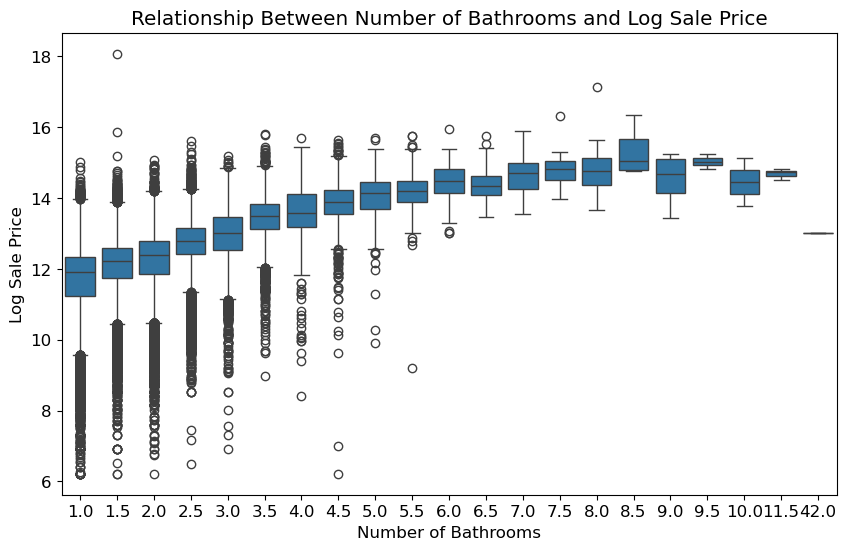

In [101]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=training_data["Bathrooms"], y=training_data["Log Sale Price"])

plt.xlabel("Number of Bathrooms")
plt.ylabel("Log Sale Price")
plt.title("Relationship Between Number of Bathrooms and Log Sale Price")

plt.show()

<!-- END QUESTION -->

Now, I'll take a look at the relationship between neighborhood and sale prices of the houses in our dataset.
Notice that currently I don't have the actual names for the neighborhoods. Instead I will use a similar column, `Neighborhood Code` (which is a numerical encoding of the actual neighborhoods by the Assessment office).

<br><br>

---
## Part 6-1

Before creating any visualization, I'll quickly inspect how many different neighborhoods we are dealing with.

Assign the variable `num_neighborhoods` to the total number of unique neighborhoods in `training_data`. 


In [102]:
num_neighborhoods = training_data['Neighborhood Code'].nunique()
num_neighborhoods

193

<br><br>

---
## Part 6-2

If I try directly plotting the distribution of `Log Sale Price` for all of the households in each neighborhood using the `plot_categorical` function from the next cell, I get the following visualization.


In [104]:
# Feel free to create a cell below this and run plot_categorical(training_data) if you want to see what this function outputs.
def plot_categorical(neighborhoods):
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x='Neighborhood Code',
        y='Log Sale Price',
        data=neighborhoods,
        ax=axs[0],
    )

    sns.countplot(
        x='Neighborhood Code',
        data=neighborhoods,
        ax=axs[1],
    )

    # Draw median price
    axs[0].axhline(
        y=training_data['Log Sale Price'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)

Oh no, looks like I have run into the problem of overplotting again! 

I might have noticed that the graph is overplotted because **there are actually quite a few neighborhoods in our dataset**! For the clarity of our visualization, I will have to zoom in again on a few of them. The reason for this is our visualization will become quite cluttered with a super dense x-axis.

I will assign the variable `in_top_20_neighborhoods` to a copy of `training_data` that has been filtered to only contain rows corresponding to properties that are in one of the top 20 most popular neighborhoods. We define the top 20 most popular neighborhoods as being the 20 neighborhood codes that have the greatest number of property sales within them.

In [105]:
top_20_neighborhood_codes = (training_data["Neighborhood Code"].value_counts().head(20).index)
in_top_20_neighborhoods = training_data[training_data["Neighborhood Code"].isin(top_20_neighborhood_codes)].copy()

I'll create another of the distribution of sale price within in each neighborhood again, but this time with a narrower focus!

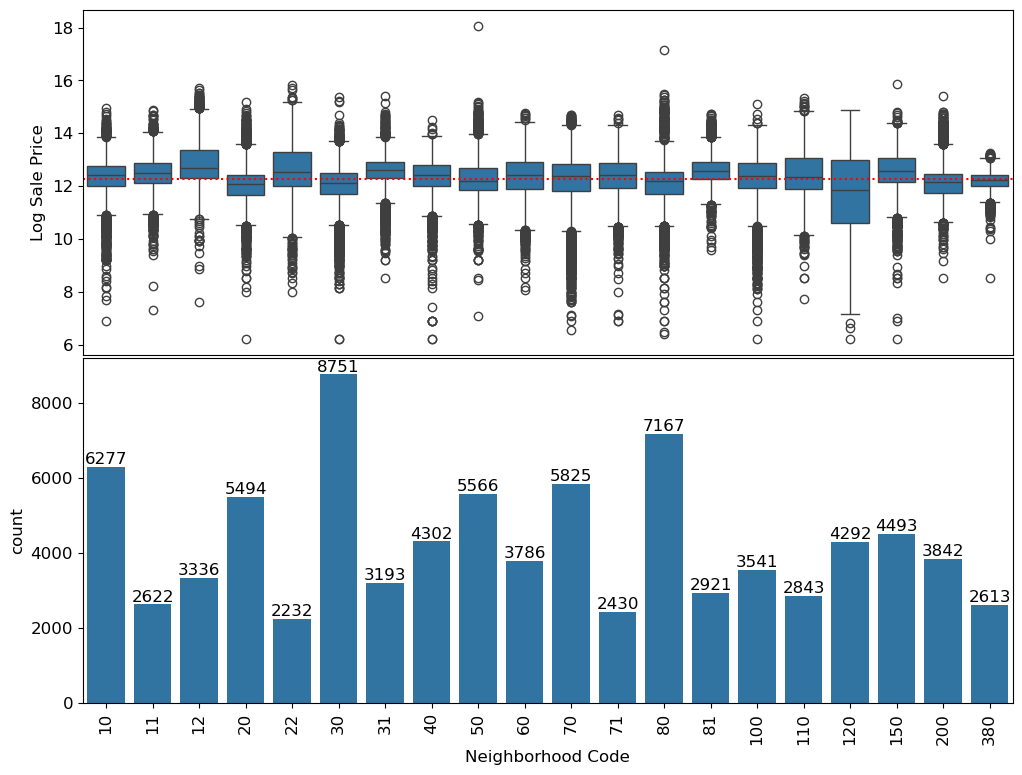

In [107]:
plot_categorical(neighborhoods=in_top_20_neighborhoods)

<br><br>

---
## Part 6-3

From the plot above, I can see that there is much less data available for some neighborhoods. For example, Neighborhood 71 has only around 27% of the number of datapoints as Neighborhood 30.

One way I can deal with the lack of data from some neighborhoods is to create a new feature that bins neighborhoods together. I’ll categorize our neighborhoods in a crude way. In this question, I’ll compute how “expensive” each neighborhood is by aggregating the `Log Sale Price`s for all properties in a particular neighborhood using a `metric`, such as the median. I’ll use this `metric` to find the top `n` most expensive neighborhoods. Then, in `q6d`, I’ll label these “expensive neighborhoods” and leave all other neighborhoods unmarked.

I'll fill in `find_expensive_neighborhoods` to return a **list** of the neighborhood codes of the **top `n`** most expensive neighborhoods as measured by our choice of aggregating function, `metric`.

For example, calling `find_expensive_neighborhoods(training_data, n=3, metric=np.median)` should return the 3 neighborhood codes with the highest median `Log Sale Price` computed across all properties in those neighborhood codes. 

In [109]:
def find_expensive_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (DataFrame): should contain at least an int-valued 'Neighborhood Code'
        and a numeric 'Log Sale Price' column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the the neighborhood codes of the top n highest-priced neighborhoods 
      as measured by the metric function
    """
    neighborhoods = (data.groupby("Neighborhood Code")["Log Sale Price"].agg(metric).nlargest(n).index)
    
    # This makes sure the final list contains the generic int type used in Python3, not specific ones used in NumPy.
    return [int(code) for code in neighborhoods]

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
expensive_neighborhoods

[44, 94, 93]

<br><br>

---
## Part 6-4

I now have a list of neighborhoods we've deemed as higher-priced than others.  I'll use that information to write an additional function `add_in_expensive_neighborhood` that takes in a `DataFrame` of housing data (`data`) and a list of neighborhood codes considered to be expensive (`expensive_neighborhoods`). 

Using these inputs, `add_in_expensive_neighborhood` should add a column to `data` named `in_expensive_neighborhood` that takes on the **integer** value of 1 if a property is part of a neighborhood in `expensive_neighborhoods` and the integer value of 0 if it is not. This type of variable is known as an **indicator variable**.

In [115]:
def add_in_expensive_neighborhood(data, expensive_neighborhoods):
    """
    Input:
      data (DataFrame): a DataFrame containing a 'Neighborhood Code' column with values
        found in the codebook
      expensive_neighborhoods (list of ints): ints should be the neighborhood codes of
        neighborhoods pre-identified as expensive
    Output:
      DataFrame identical to the input with the addition of a binary
      in_expensive_neighborhood column
    """
    data = data.copy()
    data['in_expensive_neighborhood'] = data['Neighborhood Code'].isin(expensive_neighborhoods).astype(int)
    return data

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
training_data = add_in_expensive_neighborhood(training_data, expensive_neighborhoods)

In the following question, I will take a closer look at the `Wall Material` feature of the dataset and examine how we can incorporate categorical features into our linear model.

<br><br>

---
## Part 7-1

If I look at `codebook.txt` carefully, I can see that the Assessor's Office uses the following mapping for the numerical values in the `Wall Material` column.
```
Other Heating (Nominal): 

       1    Wood
       2    Masonry
       3    Wood&Masonry
       4    Stucco

```

I'll write a function `substitute_wall_material` that replaces each numerical value in `Wall Material` with their corresponding heating source. My function should return a new `DataFrame`, not modify the existing `DataFrame`.

In [117]:
def substitute_wall_material(data):
    """
    Input:
      data (DataFrame): a DataFrame containing a 'Wall Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      new DataFrame identical to the input except with a refactored 'Wall Material' column
    """
    wall_material_mapping = {
        1: "Wood",
        2: "Masonry",
        3: "Wood&Masonry",
        4: "Stucco"
    }
    new_data = data.copy()
    new_data["Wall Material"] = new_data["Wall Material"].replace(wall_material_mapping)

    return new_data
    
training_data_mapped = substitute_wall_material(training_data)
training_data_mapped.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Bathrooms,Bathrooms Squared,in_expensive_neighborhood
1,13272240180000,202,120,3780.0,71,0.0,Masonry,1.0,1.0,1.0,...,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244,1.0,1.00,0
2,25221150230000,202,210,4375.0,70,0.0,Masonry,1.0,2.0,3.0,...,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0,9.998798,1.0,1.00,0
3,10251130030000,203,220,4375.0,17,0.0,Wood&Masonry,1.0,1.0,3.0,...,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0,12.323856,1.5,2.25,0
4,31361040550000,202,120,8400.0,32,0.0,Wood&Masonry,1.0,2.0,3.0,...,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705,1.0,1.00,0
6,30314240080000,203,181,10890.0,37,0.0,Wood,1.0,1.0,3.0,...,1,1.0,181,37181,"This property, sold on 10/26/2017, is a one-st...",10890.0,11.512925,1.5,2.25,0


<br><br>

---
## Part 7-2

#### An Important Note on One-Hot-Encoding 

Unfortunately, simply replacing the integers with the appropriate strings isn’t sufficient for using `Wall Material` in our model.  Since `Wall Material` is a categorical variable, I will have to one-hot-encode the data. For more information on why I want to use one-hot-encoding, refer to this [link](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/).

I'll complete the following function `ohe_wall_material` that returns a `DataFrame` with the new column one-hot-encoded on the wall material of the household. These new columns should have the form `Wall Material_MATERIAL`. My function should return a new `DataFrame` and **should not modify the existing `DataFrame`**.

I should use `scikit-learn`’s `OneHotEncoder` to perform the one-hot-encoding. `OneHotEncoder` will automatically generate column names of the form `Wall Material_MATERIAL`. Refer back to the video walkthrough for Question 1 of Lab 7 for an example of its use. Unlike in the lab example however, in this problem we only wish to construct the one-hot-encoding columns **without removing any columns**.

In [120]:
from sklearn.preprocessing import OneHotEncoder

def ohe_wall_material(data):
    """
    One-hot-encodes wall material. New columns are of the form "Wall Material_MATERIAL".
    """
    new_data = data.copy()
    ohe = OneHotEncoder(sparse=False, drop=None)
    encoded = ohe.fit_transform(new_data[['Wall Material']])
    column_names = [f"Wall Material_{cat}" for cat in ohe.categories_[0]]
    encoded_df = pd.DataFrame(encoded, columns=column_names, index=new_data.index)
    new_data = pd.concat([new_data, encoded_df], axis=1)
    return new_data

training_data_ohe = ohe_wall_material(training_data_mapped)
# This line of code will display only the one-hot-encoded columns in training_data_ohe that 
# have names that begin with “Wall Material_" 
training_data_ohe.filter(regex='^Wall Material_').head(10)

,Wall Material_Masonry,Wall Material_Stucco,Wall Material_Wood,Wall Material_Wood&Masonry
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0
6,0.0,0.0,1.0,0.0
7,0.0,0.0,1.0,0.0
8,1.0,0.0,0.0,0.0
9,0.0,0.0,1.0,0.0
10,0.0,0.0,1.0,0.0
11,1.0,0.0,0.0,0.0
